
# Part 4 — Comprehensive Case Study: Recipe Review Ratings Prediction

**Dataset:** `recipe_reviews.csv`  
**Goal:** Build a reproducible pipeline to clean data, explore patterns, engineer features, train/evaluate models for predicting star ratings (1–5), and report insights aligned with the rubric.


In [69]:

# Core libraries were imported to enable data handling, modeling, and visualization.
# Core Python utilities
import os
import re
import html

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle, FancyArrow

# Scikit-learn: model selection and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# Scikit-learn: models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Scikit-learn: evaluation metrics
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score, precision_recall_fscore_support,
    classification_report, roc_auc_score,
    mean_squared_error, r2_score
)


# A random seed was fixed for reproducibility.
np.random.seed(42)


## 1. Data Loading and Initial Review

In this step, the dataset was loaded and an initial inspection was performed to verify its structure.  
The objective was to confirm the number of rows and columns, examine the column names and data types, preview the first rows, and identify missing values.  
This stage ensured that the dataset was properly imported and provided an overview of its quality and potential issues that would later be addressed during data cleaning.


In [70]:
# The dataset was loaded to confirm its shape and column names. A local path was attempted first.
DATA_PATH_LOCAL = "recipe_reviews.csv"
DATA_PATH_FALLBACK = "/mnt/data/recipe_reviews.csv"

try:
    df = pd.read_csv(DATA_PATH_LOCAL)
except FileNotFoundError:
    df = pd.read_csv(DATA_PATH_FALLBACK)

# Dataset shape was displayed.
print(">>> Table 1: Dataset shape (rows and columns)")
display(pd.DataFrame({"Rows": [df.shape[0]], "Columns": [df.shape[1]]}))

# Column names and dtypes were displayed as a dataframe.
print(">>> Table 2: Column names and their dtypes")
dtypes_df = pd.DataFrame(df.dtypes, columns=["dtype"]).reset_index().rename(columns={"index": "column"})
display(dtypes_df.head(24))

# A snapshot of the dataset was displayed.
print(">>> Table 3: First 5 rows of the dataset")
display(df.head(5))

# Missing ratio by column was displayed as a dataframe.
print(">>> Table 4: Top 10 columns with highest missing ratio")
missing_df = df.isna().mean().reset_index().rename(columns={"index": "column", 0: "missing_ratio"})
missing_df = missing_df.sort_values("missing_ratio", ascending=False)
display(missing_df.head(10))


>>> Table 1: Dataset shape (rows and columns)


,Rows,Columns
0,18182,24


>>> Table 2: Column names and their dtypes


,column,dtype
0,Unnamed: 0,int64
1,recipe_number,int64
2,recipe_code,int64
3,likes_score,float64
4,dislike_index,float64
5,response_level,float64
6,user_index,float64
7,ranking_value,float64
8,vote_ratio,float64
9,score_log,float64


>>> Table 3: First 5 rows of the dataset


,Unnamed: 0,recipe_number,recipe_code,likes_score,dislike_index,response_level,user_index,ranking_value,vote_ratio,score_log,...,user_id,user_name,user_score,created_at,responses,likes,dislikes,ranking_score,text,stars
0,0,1,14299,0.104335,-0.087082,-0.001580,1.172032,539.698328,0.000000,0.693147,...,u_9iFLIhMa8QaG,Jeri326,1,1665619889,0,0,0,527,"I tweaked it a little, removed onions because ...",5
1,1,1,14299,6.970958,-0.094496,-0.002169,50.629458,720.511995,0.875000,3.931826,...,u_Lu6p25tmE77j,Mark467,50,1665277687,0,7,0,724,Bush used to have a white chili bean and it ma...,5
2,2,1,14299,3.136047,-0.047194,0.014539,10.742998,717.194563,0.750000,2.397895,...,u_s0LwgpZ8Jsqq,Barbara566,10,1664404557,0,3,0,710,I have a very complicated white chicken chili ...,5
3,3,1,14299,2.319913,-0.107932,2.012194,0.865812,585.875342,0.666667,0.693147,...,u_fqrybAdYjgjG,jeansch123,1,1661787808,2,2,0,581,"In your introduction, you mentioned cream chee...",0
4,4,1,14299,6.950816,0.142649,1.009770,8.985971,815.148751,0.875000,2.397895,...,u_XXWKwVhKZD69,camper77,10,1664913823,1,7,0,820,Wonderful! I made this for a &#34;Chili/Stew&#...,0


>>> Table 4: Top 10 columns with highest missing ratio


,column,missing_ratio
22,text,0.00011
0,Unnamed: 0,0.00000
2,recipe_code,0.00000
1,recipe_number,0.00000
4,dislike_index,0.00000
5,response_level,0.00000
6,user_index,0.00000
3,likes_score,0.00000
7,ranking_value,0.00000
8,vote_ratio,0.00000


## 2. Data Cleaning

In this step, the dataset was cleaned to resolve common data quality issues.  
The automatically generated index column was removed, and date fields were converted to the correct format to enable temporal analysis.  
The placeholder value "2" was replaced with proper missing values to ensure consistency across categorical features.  
Invalid target values outside the 1–5 range were eliminated, and duplicate records were identified and removed.  
A summary of missing values after cleaning was displayed to assess data quality and confirm the integrity of the dataset for further analysis.


In [71]:
# An export-generated index column was dropped because it did not carry information.
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# The created_at column was converted into datetime for temporal analysis.
if "created_at" in df.columns:
    df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")

# The placeholder value '2' was replaced with NaN in categorical columns to reflect true missingness.
categorical_cols = df.select_dtypes(include="object").columns.tolist()
if len(categorical_cols) > 0:
    for c in categorical_cols:
        df[c] = df[c].replace("2", np.nan)

# A brief report of missing values after replacement was displayed.
print(">>> Table 5: Top 10 columns with highest missing ratio after cleaning '2'")
missing_df = df.isna().mean().reset_index().rename(columns={"index": "column", 0: "missing_ratio"})
missing_df = missing_df.sort_values("missing_ratio", ascending=False)
display(missing_df.head(10))

# The target column 'stars' was validated to contain values 1–5, and invalid values were removed.
if "stars" in df.columns:
    valid_mask = df["stars"].isin([1,2,3,4,5])
    removed = (~valid_mask).sum()
    df = df.loc[valid_mask].copy()
    print(">>> Table 6: Number of rows removed due to invalid 'stars' values")
    display(pd.DataFrame({"Rows_removed_invalid_stars": [removed]}))

# Duplicate records were reviewed and removed using a preferred key if available.
if "comment_id" in df.columns:
    before = df.shape[0]
    df = df.drop_duplicates(subset=["comment_id"]).copy()
    after = df.shape[0]
    print(">>> Table 7: Number of duplicate rows removed using 'comment_id'")
    display(pd.DataFrame({"Duplicates_removed": [before - after]}))
else:
    heuristic_key = [c for c in ["user_id","text","created_at"] if c in df.columns]
    if len(heuristic_key) > 0:
        before = df.shape[0]
        df = df.drop_duplicates(subset=heuristic_key).copy()
        after = df.shape[0]
        print(">>> Table 7: Number of duplicate rows removed using heuristic keys")
        display(pd.DataFrame({"Duplicates_removed": [before - after]}))


>>> Table 5: Top 10 columns with highest missing ratio after cleaning '2'


,column,missing_ratio
21,text,0.00011
1,recipe_code,0.00000
0,recipe_number,0.00000
3,dislike_index,0.00000
4,response_level,0.00000
5,user_index,0.00000
2,likes_score,0.00000
6,ranking_value,0.00000
7,vote_ratio,0.00000
9,region,0.00000


>>> Table 6: Number of rows removed due to invalid 'stars' values


,Rows_removed_invalid_stars
0,1696


>>> Table 7: Number of duplicate rows removed using 'comment_id'


,Duplicates_removed
0,0


## 3. Exploratory Data Analysis (EDA)

In this step, exploratory analysis was conducted to better understand the structure and patterns of the dataset.  
Summary statistics were generated for numerical variables, and the cardinality of categorical features was reviewed.  
Distributions of key categorical features were inspected to detect potential imbalances, while correlations among numerical variables were examined to identify relevant relationships.  
The distribution of star ratings was visualized to assess class imbalance, and boxplots were produced to explore how engagement metrics such as likes, dislikes, and responses varied across rating levels.  
Additionally, review length was analyzed as an indicator of textual richness and its potential association with higher or lower star ratings.  
These insights provided a foundation for feature engineering and model building in later steps.


>>> Table 8: Summary statistics for numeric features


,count,mean,std,min,25%,50%,75%,max
recipe_number,16486.0,38.537183,29.874201,1.000000,11.000000,32.000000,63.000000,100.000000
recipe_code,16486.0,21628.928121,24258.298025,386.000000,6086.000000,14299.000000,32535.000000,191775.000000
likes_score,16486.0,1.020802,3.952783,-0.805890,-0.096548,0.079747,0.377301,105.766878
dislike_index,16486.0,0.490405,3.193160,-0.774810,-0.100303,0.027270,0.184376,126.052512
response_level,16486.0,0.010823,0.115811,-0.029633,-0.004550,0.000147,0.004847,3.003453
user_index,16486.0,2.212846,10.423444,-1.093772,0.678191,1.042261,1.417334,520.440341
ranking_value,16486.0,151.117352,137.512424,-7.732879,96.769451,102.627594,112.956825,944.834309
vote_ratio,16486.0,0.128501,0.255221,0.000000,0.000000,0.000000,0.000000,0.976744
score_log,16486.0,0.817916,0.530352,0.000000,0.693147,0.693147,0.693147,6.255750
user_score,16486.0,2.211573,10.407196,0.000000,1.000000,1.000000,1.000000,520.000000


>>> Table 9: Cardinalities (number of unique values) for categorical features


,column,n_unique
3,comment_id,16486
6,text,16096
4,user_id,12420
5,user_name,12228
2,recipe_name,100
0,region,4
1,device_type,3


>>> Table 10: Top categories (up to 10) for selected categorical features
>>> Top categories for 'region' (showing up to 10)


,region,count
0,West,4174
1,North,4149
2,South,4110
3,East,4053


>>> Top categories for 'device_type' (showing up to 10)


,device_type,count
0,Mobile,5526
1,Desktop,5487
2,Tablet,5473


>>> Top categories for 'recipe_name' (showing up to 10)


,recipe_name,count
0,Cheeseburger Soup,700
1,Creamy White Chili,601
2,Best Ever Banana Bread,485
3,Favorite Chicken Potpie,369
4,Enchilada Casser-Ole!,367
5,Flavorful Chicken Fajitas,345
6,Basic Homemade Bread,326
7,Zucchini Pizza Casserole,324
8,Amish Breakfast Casserole,323
9,Cauliflower Soup,308


>>> Figure 1: Star rating distribution (counts)


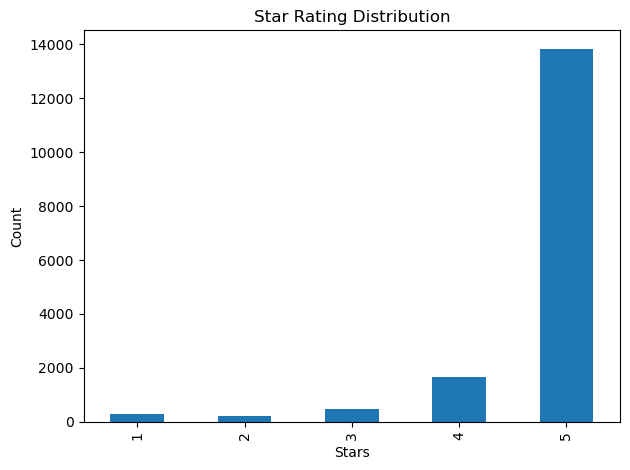

>>> Figure 2: Correlation heatmap for numeric features


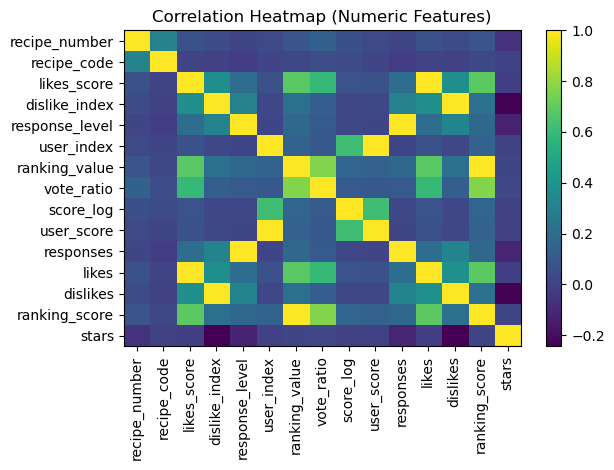

>>> Figure 3: Distribution of 'likes' by star rating (boxplot)


<Figure size 640x480 with 0 Axes>

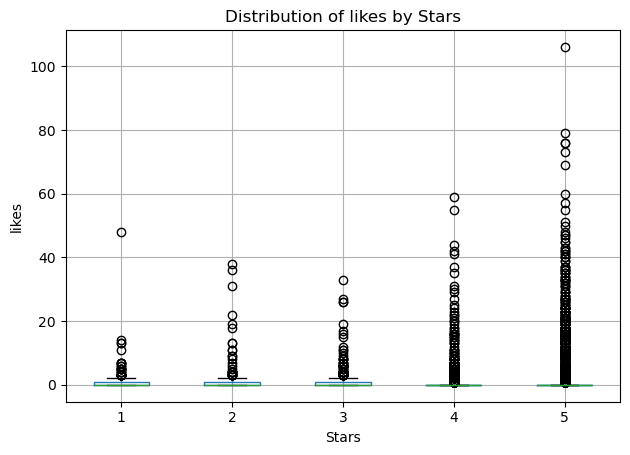

>>> Figure 4: Distribution of 'dislikes' by star rating (boxplot)


<Figure size 640x480 with 0 Axes>

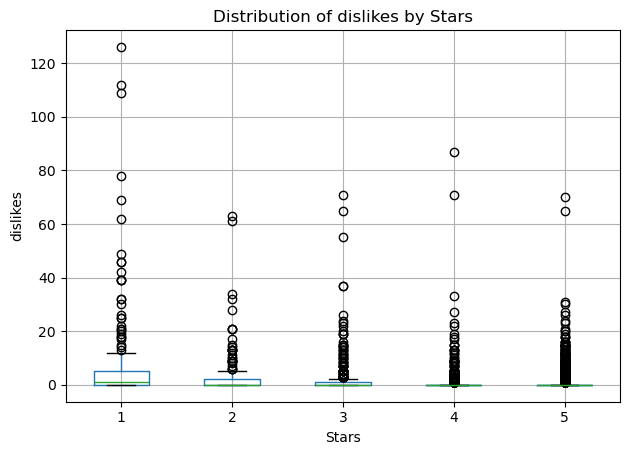

>>> Figure 5: Distribution of 'responses' by star rating (boxplot)


<Figure size 640x480 with 0 Axes>

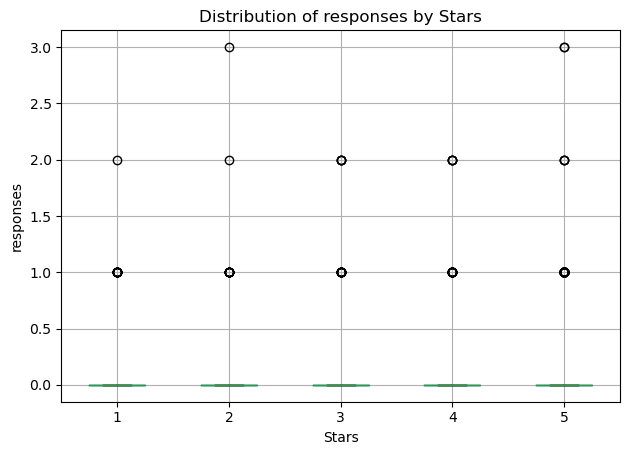

>>> Figure 6: Distribution of 'user_score' by star rating (boxplot)


<Figure size 640x480 with 0 Axes>

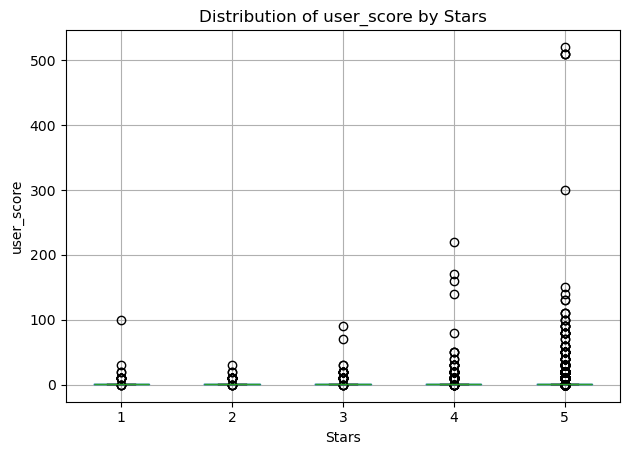

>>> Figure 7: Distribution of 'ranking_value' by star rating (boxplot)


<Figure size 640x480 with 0 Axes>

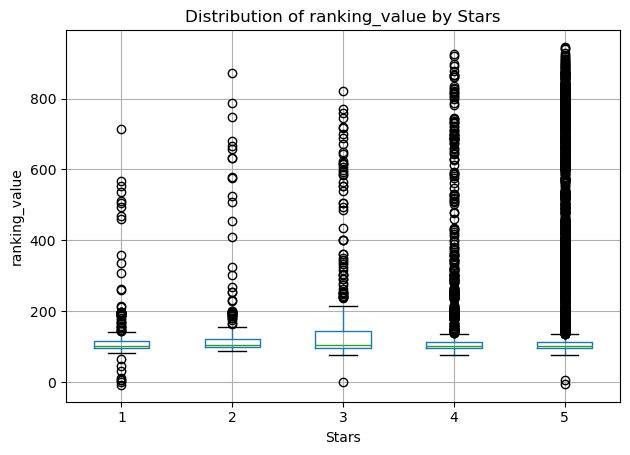

>>> Figure 8: Distribution of review text length (characters) by star rating (boxplot)


<Figure size 640x480 with 0 Axes>

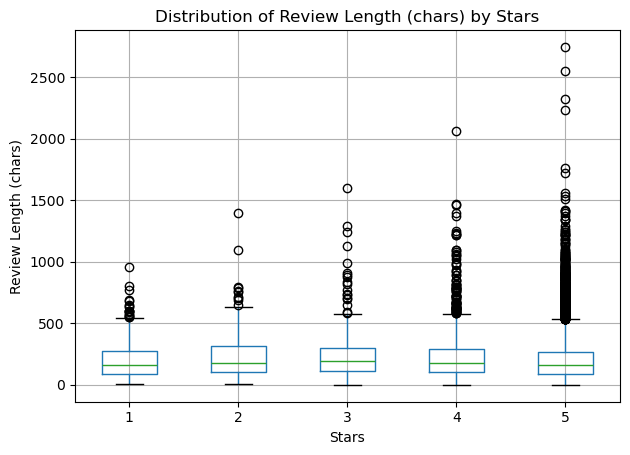

In [72]:
# Descriptive statistics for numeric features were generated.

# Table 8: Summary statistics for numeric features
print(">>> Table 8: Summary statistics for numeric features")
num_cols_eda = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols_eda) > 0:
    desc_num = df[num_cols_eda].describe().T
    display(desc_num)
else:
    display(pd.DataFrame({"note": ["No numeric features were found."]}))

# Table 9: Cardinalities of categorical features (unique counts)
print(">>> Table 9: Cardinalities (number of unique values) for categorical features")
cat_cols_eda = df.select_dtypes(include=["object"]).columns.tolist()
if len(cat_cols_eda) > 0:
    card = pd.DataFrame(
        {"column": cat_cols_eda,
         "n_unique": [df[c].nunique(dropna=True) for c in cat_cols_eda]}
    ).sort_values("n_unique", ascending=False)
    display(card)
else:
    display(pd.DataFrame({"note": ["No categorical features were found."]}))

# Table 10: Top categories (up to 10) for selected categorical features
print(">>> Table 10: Top categories (up to 10) for selected categorical features")
top_cat_tables = []
selected_cats = [c for c in ["region", "device_type", "recipe_name"] if c in cat_cols_eda]
if len(selected_cats) == 0 and len(cat_cols_eda) > 0:
    # A fallback was used in case the preferred columns were not present.
    selected_cats = cat_cols_eda[:2]

if len(selected_cats) > 0:
    for c in selected_cats:
        top_counts = df[c].value_counts(dropna=False).head(10).reset_index()
        top_counts.columns = [c, "count"]
        print(">>> Top categories for '{}' (showing up to 10)".format(c))
        display(top_counts)
else:
    display(pd.DataFrame({"note": ["No categorical features were available for top-count display."]}))

# --- FIGURES ---

# Figure 1: Star rating distribution (counts) was plotted to assess class imbalance.
if "stars" in df.columns:
    print(">>> Figure 1: Star rating distribution (counts)")
    counts = df["stars"].value_counts().sort_index()
    counts.plot(kind="bar")  # No plt.figure() here to avoid empty figure output
    plt.title("Star Rating Distribution")
    plt.xlabel("Stars")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# Figure 2: Correlation heatmap for numeric features was plotted.
if len(num_cols_eda) > 1:
    print(">>> Figure 2: Correlation heatmap for numeric features")
    corr = df[num_cols_eda].corr(numeric_only=True)
    plt.figure()  # Matplotlib-only plot needs a figure
    plt.imshow(corr, aspect="auto")
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.tight_layout()
    plt.show()

# Figures 3+: Boxplots of selected numeric features by star rating were plotted.
selected_num_for_box = [c for c in ["likes", "dislikes", "responses", "user_score", "ranking_value"] if c in df.columns]
fig_counter = 3
if "stars" in df.columns and len(selected_num_for_box) > 0:
    for c in selected_num_for_box:
        print(">>> Figure {}: Distribution of '{}' by star rating (boxplot)".format(fig_counter, c))
        plt.figure()  # Boxplot requires a figure
        df.boxplot(column=c, by="stars")
        plt.title("Distribution of {} by Stars".format(c))
        plt.suptitle("")
        plt.xlabel("Stars")
        plt.ylabel(c)
        plt.tight_layout()
        plt.show()
        fig_counter += 1

# Optional Figure: Review text length by stars was explored via boxplot.
if "stars" in df.columns and "text" in df.columns:
    print(">>> Figure {}: Distribution of review text length (characters) by star rating (boxplot)".format(fig_counter))
    temp_len = df["text"].fillna("").apply(len)
    temp_df = pd.DataFrame({"stars": df["stars"], "review_len_chars": temp_len})
    plt.figure()  # Boxplot requires a figure
    temp_df.boxplot(column="review_len_chars", by="stars")
    plt.title("Distribution of Review Length (chars) by Stars")
    plt.suptitle("")
    plt.xlabel("Stars")
    plt.ylabel("Review Length (chars)")
    plt.tight_layout()
    plt.show()


## 4. Feature Engineering

In this step, new features were engineered to improve the predictive capacity of the models.  
The review text was preprocessed by decoding HTML entities and by creating derived variables such as text length, word count, punctuation markers, uppercase ratio, and digit ratio.  
Categorical features were normalized to lower case and trimmed to ensure consistency, while high-cardinality variables such as recipe names were simplified using a Top-N strategy.  
Numerical engagement features, including likes, dislikes, and responses, were transformed with logarithmic scaling to reduce skewness.  
These engineered features enriched the dataset by capturing linguistic, behavioral, and structural patterns that were expected to be influential for star rating prediction.


In [73]:
# Basic text and categorical normalization were applied; simple text-derived features were engineered;
# and log1p transforms were prepared for skewed count-like variables.

engineered_cols = []

# Text was decoded from HTML entities and normalized (without altering original schema beyond safe cleaning).
if "text" in df.columns:
    # HTML entities were decoded and missing values were filled with empty strings.
    df["text"] = df["text"].fillna("").apply(html.unescape)
    
    # Simple text-derived features were created to capture length and emphasis patterns.
    df["review_len_chars"] = df["text"].apply(len)
    df["review_len_words"] = df["text"].apply(lambda s: len(s.split()))
    df["exclam_count"] = df["text"].str.count(r"!")
    df["question_count"] = df["text"].str.count(r"\?")
    
    # Uppercase and digit ratios were computed (guarding against division by zero).
    def _upper_ratio(s):
        letters = [ch for ch in s if ch.isalpha()]
        if len(letters) == 0:
            return 0.0
        upp = sum(1 for ch in letters if ch.isupper())
        return float(upp) / float(len(letters))
    
    def _digit_ratio(s):
        if len(s) == 0:
            return 0.0
        digs = sum(1 for ch in s if ch.isdigit())
        return float(digs) / float(len(s))
    
    df["uppercase_ratio"] = df["text"].apply(_upper_ratio)
    df["digit_ratio"] = df["text"].apply(_digit_ratio)
    
    engineered_cols += [
        "review_len_chars", "review_len_words", "exclam_count",
        "question_count", "uppercase_ratio", "digit_ratio"
    ]

# Selected categorical columns were normalized (lowercased and stripped) to reduce sparsity.
cat_to_normalize = [c for c in ["region", "device_type", "recipe_name"] if c in df.columns]
for c in cat_to_normalize:
    df[c] = df[c].astype("object")
    df[c] = df[c].fillna("missing").astype(str).str.strip().str.lower()

# High-cardinality categories were reduced using a Top-N approach to avoid excessive one-hot expansion.
# A compact representation was created for recipe_name if present.
if "recipe_name" in df.columns:
    N_TOP = 30
    topN = df["recipe_name"].value_counts(dropna=False).head(N_TOP).index
    df["recipe_name_top"] = np.where(df["recipe_name"].isin(topN), df["recipe_name"], "other")
    engineered_cols.append("recipe_name_top")

# Log1p transforms were prepared for skewed count-like numeric variables.
candidate_skew = [c for c in ["likes", "dislikes", "responses", "ranking_value", "ranking_score"] if c in df.columns]
for c in candidate_skew:
    # Only numeric columns were transformed; non-numeric were skipped safely.
    if pd.api.types.is_numeric_dtype(df[c]):
        new_col = c + "_log1p"
        df[new_col] = np.log1p(df[c].clip(lower=0))
        engineered_cols.append(new_col)

# A summary table of engineered columns was displayed.
print(">>> Table 11: Engineered features that were added to the dataset")
if len(engineered_cols) > 0:
    eng_summary = pd.DataFrame({
        "engineered_feature": engineered_cols,
        "dtype": [df[c].dtype for c in engineered_cols]
    })
    display(eng_summary)
else:
    display(pd.DataFrame({"note": ["No engineered features were created in this step."]}))

# A preview of engineered feature values was displayed.
print(">>> Table 12: Head preview of engineered features (first 8 rows)")
if len(engineered_cols) > 0:
    display(df[engineered_cols].head(8))
else:
    display(pd.DataFrame({"note": ["No engineered features to preview."]}))

# Cardinalities for newly created categorical engineered columns were reported.
print(">>> Table 13: Cardinalities for engineered categorical features")
cat_eng = [c for c in engineered_cols if c in df.columns and pd.api.types.is_object_dtype(df[c])]
if len(cat_eng) > 0:
    card_eng = pd.DataFrame({
        "column": cat_eng,
        "n_unique": [df[c].nunique(dropna=True) for c in cat_eng]
    }).sort_values("n_unique", ascending=False)
    display(card_eng)
else:
    display(pd.DataFrame({"note": ["No engineered categorical features were found."]}))


>>> Table 11: Engineered features that were added to the dataset


,engineered_feature,dtype
0,review_len_chars,int64
1,review_len_words,int64
2,exclam_count,int64
3,question_count,int64
4,uppercase_ratio,float64
5,digit_ratio,float64
6,recipe_name_top,object
7,likes_log1p,float64
8,dislikes_log1p,float64
9,responses_log1p,float64


>>> Table 12: Head preview of engineered features (first 8 rows)


,review_len_chars,review_len_words,exclam_count,question_count,uppercase_ratio,digit_ratio,recipe_name_top,likes_log1p,dislikes_log1p,responses_log1p,ranking_value_log1p,ranking_score_log1p
0,355,67,1,0,0.017921,0.000000,creamy white chili,0.000000,0.000000,0.0,6.292862,6.269096
1,138,27,1,0,0.018519,0.000000,creamy white chili,2.079442,0.000000,0.0,6.581349,6.586172
2,354,63,2,0,0.031690,0.000000,creamy white chili,1.386294,0.000000,0.0,6.576741,6.566672
5,73,14,3,0,0.000000,0.000000,creamy white chili,1.386294,0.693147,0.0,6.252124,6.251904
6,181,35,8,0,0.045802,0.011050,creamy white chili,2.484907,0.000000,0.0,6.737705,6.726233
8,445,85,1,0,0.050296,0.011236,creamy white chili,1.945910,0.000000,0.0,6.544272,6.542472
9,95,23,0,0,0.014286,0.000000,creamy white chili,0.000000,0.000000,0.0,5.977313,6.003887
10,36,6,0,0,0.033333,0.000000,creamy white chili,1.386294,0.000000,0.0,6.564612,6.561031


>>> Table 13: Cardinalities for engineered categorical features


,column,n_unique
0,recipe_name_top,31


## 5. Train–Test Split

In this step, the dataset was divided into training and testing subsets to enable model evaluation on unseen data.  
Non-predictive and identifier columns such as user IDs, comment IDs, and timestamps were excluded to prevent data leakage.  
Feature lists were organized into three categories: numerical, categorical, and textual variables, in preparation for the preprocessing pipeline.  
A stratified 80-20 sampling strategy was applied to preserve the original distribution of star ratings across the train and test sets.  
Class distributions were reviewed in both subsets to confirm that proportions were maintained, ensuring that the evaluation would be fair and representative of the dataset.


In [74]:
# Features and target were defined and split into train and test sets using stratification.
# The setup was adapted to the dataset to preserve class distribution and to avoid leakage from ID-like fields.

# Target was defined.
target = "stars"
assert target in df.columns, "The target column 'stars' was not found."

# ID-like and non-predictive columns were excluded to prevent leakage.
exclude_cols = [target, "comment_id", "user_id", "user_name", "recipe_code", "recipe_number", "created_at"]
exclude_cols = [c for c in exclude_cols if c in df.columns]

# Feature columns were prepared.
feature_cols = [c for c in df.columns if c not in exclude_cols]

# A quick summary of feature dtypes was displayed to plan preprocessing.
print(">>> Table 14: Feature columns by dtype")
feat_types = pd.DataFrame({
    "column": feature_cols,
    "dtype": [df[c].dtype for c in feature_cols]
})
display(feat_types.head(30))

# Text, numeric, and categorical feature lists were derived for downstream preprocessing.
text_col = "text" if "text" in feature_cols else None
numeric_features = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df[c])]
categorical_features = [c for c in feature_cols if pd.api.types.is_object_dtype(df[c])]
# The text column was excluded from categorical features if present.
if text_col and text_col in categorical_features:
    categorical_features.remove(text_col)

print(">>> Table 15: Lists of features by role (first rows if long)")
roles_df = pd.DataFrame({
    "text_feature": [text_col] if text_col else [],
})
# Separate displays were used for readability.
display(pd.DataFrame({"numeric_features": numeric_features[:25]}))
display(pd.DataFrame({"categorical_features": categorical_features[:25]}))
if text_col:
    display(pd.DataFrame({"text_feature": [text_col]}))
else:
    display(pd.DataFrame({"text_feature": ["None"]}))

# Features and target were selected.
X = df[feature_cols].copy()
y = df[target].copy()

# Class distribution was reviewed to anticipate potential imbalance issues.
print(">>> Table 16: Overall class distribution (counts and proportions)")
overall_counts = y.value_counts().sort_index()
overall_props = (y.value_counts(normalize=True).sort_index().rename("proportion"))
display(pd.concat([overall_counts.rename("count"), overall_props], axis=1))

# A stratified split was attempted to preserve class distribution in both sets.
# A fallback without stratification was used only if stratified split failed due to extremely rare classes.
test_size = 0.20
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )
    split_mode = "stratified"
except ValueError as e:
    # This can occur if some classes have too few samples for stratification.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=None, random_state=42
    )
    split_mode = "non-stratified (fallback)"
    print(">>> Warning: Stratified split failed and a non-stratified split was used. Reason: {}".format(e))

# Shapes of the splits were reported.
print(">>> Table 17: Train/Test shapes")
display(pd.DataFrame({
    "X_train_shape": [X_train.shape],
    "X_test_shape": [X_test.shape],
    "y_train_len": [len(y_train)],
    "y_test_len": [len(y_test)],
    "split_mode": [split_mode]
}))

# Class distributions in train and test were displayed to verify preservation of proportions.
print(">>> Table 18: Train set class distribution (counts and proportions)")
train_counts = y_train.value_counts().sort_index()
train_props = y_train.value_counts(normalize=True).sort_index().rename("proportion")
display(pd.concat([train_counts.rename("count"), train_props], axis=1))

print(">>> Table 19: Test set class distribution (counts and proportions)")
test_counts = y_test.value_counts().sort_index()
test_props = y_test.value_counts(normalize=True).sort_index().rename("proportion")
display(pd.concat([test_counts.rename("count"), test_props], axis=1))

# A simple diagnostic was provided to ensure all classes were present in both splits when stratification succeeded.
if split_mode == "stratified":
    missing_in_train = set(overall_counts.index) - set(train_counts.index)
    missing_in_test = set(overall_counts.index) - set(test_counts.index)
    print(">>> Diagnostic: Classes missing in train:", sorted(list(missing_in_train)))
    print(">>> Diagnostic: Classes missing in test:", sorted(list(missing_in_test)))
else:
    print(">>> Diagnostic: Non-stratified split was used; class proportions may not be preserved exactly.")


>>> Table 14: Feature columns by dtype


,column,dtype
0,likes_score,float64
1,dislike_index,float64
2,response_level,float64
3,user_index,float64
4,ranking_value,float64
5,vote_ratio,float64
6,score_log,float64
7,region,object
8,device_type,object
9,recipe_name,object


>>> Table 15: Lists of features by role (first rows if long)


,numeric_features
0,likes_score
1,dislike_index
2,response_level
3,user_index
4,ranking_value
5,vote_ratio
6,score_log
7,user_score
8,responses
9,likes


,categorical_features
0,region
1,device_type
2,recipe_name
3,recipe_name_top


,text_feature
0,text


>>> Table 16: Overall class distribution (counts and proportions)


,count,proportion
stars,,
1,280,0.016984
2,232,0.014073
3,490,0.029722
4,1655,0.100388
5,13829,0.838833


>>> Table 17: Train/Test shapes


,X_train_shape,X_test_shape,y_train_len,y_test_len,split_mode
0,"(13188, 28)","(3298, 28)",13188,3298,stratified


>>> Table 18: Train set class distribution (counts and proportions)


,count,proportion
stars,,
1,224,0.016985
2,186,0.014104
3,392,0.029724
4,1324,0.100394
5,11062,0.838793


>>> Table 19: Test set class distribution (counts and proportions)


,count,proportion
stars,,
1,56,0.016980
2,46,0.013948
3,98,0.029715
4,331,0.100364
5,2767,0.838993


>>> Diagnostic: Classes missing in train: []
>>> Diagnostic: Classes missing in test: []


## 6. Modeling Pipelines

In this step, preprocessing pipelines and predictive models were constructed.  
Textual data was vectorized using TF-IDF to capture term importance, numerical variables were standardized through scaling, and categorical features were transformed with one-hot encoding.  
These transformations were integrated into a single `ColumnTransformer` to ensure consistent and reproducible preprocessing across all models.  
Two classification models were implemented: Logistic Regression, which emphasizes linear relationships in the transformed feature space, and Random Forest, which captures non-linear interactions through an ensemble of decision trees.  
A workflow diagram was generated to illustrate the end-to-end process, from raw data input to preprocessing and final classification, providing a clear visualization of the modeling strategy.


In [75]:
# Preprocessing pipelines for text, numeric, and categorical features were defined,
# and two classifiers were prepared (Logistic Regression and Random Forest).
# A workflow diagram was also drawn to visualize the end-to-end process.

# --- SAFETY CHECKS ON FEATURE LISTS ---
# It was verified that the feature lists from the previous step were available.
assert "X_train" in globals(), "X_train was not found. Please run the Train–Test Split cell first."
assert "numeric_features" in globals(), "numeric_features was not found. Please run the Train–Test Split cell first."
assert "categorical_features" in globals(), "categorical_features was not found. Please run the Train–Test Split cell first."

# The text feature name was reconciled from previous steps.
text_feature = "text" if ("text" in X_train.columns) else None

# --- PREPROCESSING DEFINITIONS ---
text_transformer = TfidfVectorizer(ngram_range=(1, 2), min_df=5, stop_words="english")
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# The ColumnTransformer was defined to combine text, numeric, and categorical branches.
transformers = []
if text_feature:
    transformers.append(("text", text_transformer, text_feature))
if len(numeric_features) > 0:
    transformers.append(("num", numeric_transformer, numeric_features))
if len(categorical_features) > 0:
    transformers.append(("cat", categorical_transformer, categorical_features))

preprocess = ColumnTransformer(transformers=transformers, remainder="drop")

# --- PIPELINES (MIXED FEATURES) ---
pipe_lr = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000))
])

pipe_rf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))
])

# A compact summary of preprocessing configuration was displayed.
print(">>> Table 20: Preprocessing branches and assigned features")
prep_summary = []
if text_feature:
    prep_summary.append({"branch": "text", "transformer": "TfidfVectorizer(1-2 grams, min_df=5, english stopwords)", 
                         "n_features": 1, "columns_or_role": text_feature})
if len(numeric_features) > 0:
    prep_summary.append({"branch": "num", "transformer": "StandardScaler()", 
                         "n_features": len(numeric_features), "columns_or_role": ", ".join(numeric_features[:10]) + (" ..." if len(numeric_features) > 10 else "")})
if len(categorical_features) > 0:
    prep_summary.append({"branch": "cat", "transformer": "OneHotEncoder(handle_unknown='ignore')", 
                         "n_features": len(categorical_features), "columns_or_role": ", ".join(categorical_features[:10]) + (" ..." if len(categorical_features) > 10 else "")})
display(pd.DataFrame(prep_summary))

# A summary of modeling pipelines was displayed.
print(">>> Table 21: Defined modeling pipelines")
display(pd.DataFrame({
    "pipeline": ["pipe_lr", "pipe_rf"],
    "classifier": ["LogisticRegression(max_iter=1000)", "RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)"],
    "feature_space": ["Text + Numeric + Categorical", "Text + Numeric + Categorical"]
}))

# --- WORKFLOW DIAGRAM (MATPLOTLIB) ---
# A simple workflow diagram was drawn to visualize the pipeline: Inputs -> Preprocessing -> ColumnTransformer -> Model.

def _add_box(ax, xy, text):
    x, y = xy
    rect = Rectangle((x, y), 2.8, 0.9, fill=False)
    ax.add_patch(rect)
    ax.text(x + 0.05, y + 0.55, text, va="center", ha="left", fontsize=10)

def _add_arrow(ax, start_xy, end_xy):
    ax.add_patch(FancyArrow(start_xy[0], start_xy[1], end_xy[0]-start_xy[0], end_xy[1]-start_xy[1],
                            width=0.01, length_includes_head=True, head_width=0.15, head_length=0.2))


>>> Table 20: Preprocessing branches and assigned features


,branch,transformer,n_features,columns_or_role
0,text,"TfidfVectorizer(1-2 grams, min_df=5, english s...",1,text
1,num,StandardScaler(),23,"likes_score, dislike_index, response_level, us..."
2,cat,OneHotEncoder(handle_unknown='ignore'),4,"region, device_type, recipe_name, recipe_name_top"


>>> Table 21: Defined modeling pipelines


,pipeline,classifier,feature_space
0,pipe_lr,LogisticRegression(max_iter=1000),Text + Numeric + Categorical
1,pipe_rf,"RandomForestClassifier(n_estimators=300, rando...",Text + Numeric + Categorical


>>> Workflow Diagram Color Legend:
 - Light gray : Input (Raw DataFrame)
 - Light green: Feature splitting stage
 - Light blue : Preprocessing branches (TF-IDF, StandardScaler, OneHotEncoder)
 - Light yellow: ColumnTransformer (concatenation of features)
 - Light pink : Classifiers (Logistic Regression, Random Forest)

>>> Figure 3: End-to-end workflow diagram for the modeling pipelines


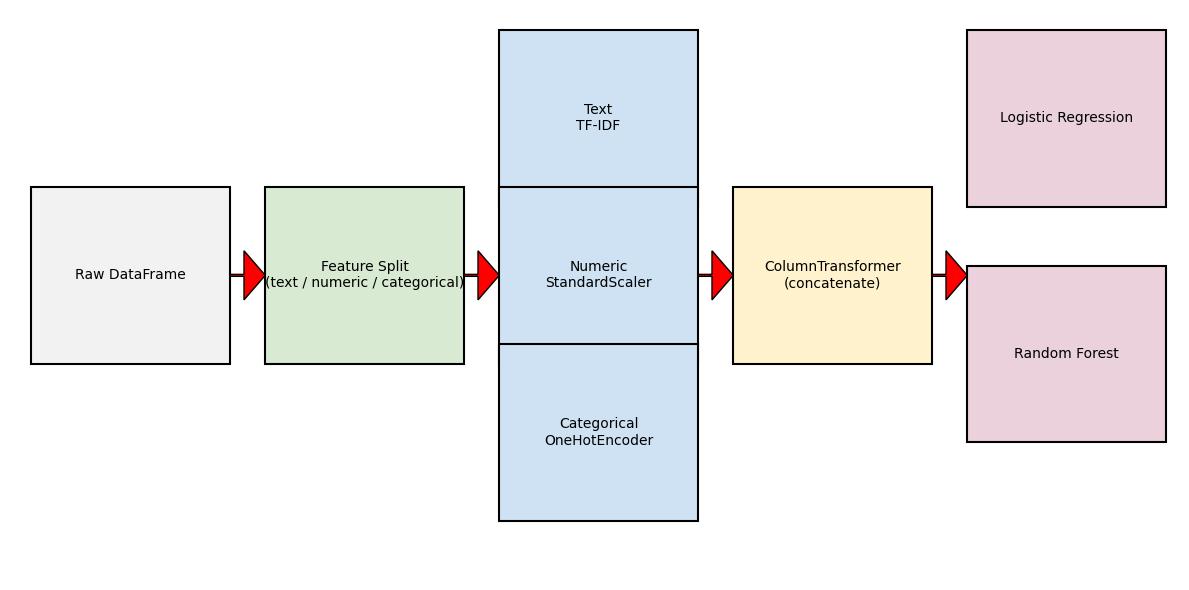

In [76]:
# A workflow diagram was drawn to visualize the pipeline: Inputs -> Preprocessing -> ColumnTransformer -> Model.

def _add_box(ax, xy, text, facecolor="white"):
    x, y = xy
    rect = Rectangle(
        (x, y), 2.8, 0.9,
        facecolor=facecolor, edgecolor="black", linewidth=1.5
    )
    ax.add_patch(rect)
    ax.text(x + 1.4, y + 0.45, text, va="center", ha="center", fontsize=10, wrap=True)

def _add_arrow(ax, start_xy, end_xy):
    ax.add_patch(FancyArrow(
        start_xy[0], start_xy[1],
        end_xy[0]-start_xy[0], end_xy[1]-start_xy[1],
        width=0.01, length_includes_head=True,
        head_width=0.25, head_length=0.3,
        facecolor="red", edgecolor="black"
    ))

# Meaning of colors was printed.
print(">>> Workflow Diagram Color Legend:")
print(" - Light gray : Input (Raw DataFrame)")
print(" - Light green: Feature splitting stage")
print(" - Light blue : Preprocessing branches (TF-IDF, StandardScaler, OneHotEncoder)")
print(" - Light yellow: ColumnTransformer (concatenation of features)")
print(" - Light pink : Classifiers (Logistic Regression, Random Forest)")

print("\n>>> Figure 3: End-to-end workflow diagram for the modeling pipelines")

fig, ax = plt.subplots(figsize=(12, 6))

# Row 1: Inputs
_add_box(ax, (0.3, 3.1), "Raw DataFrame", facecolor="#f2f2f2")  # light gray
_add_arrow(ax, (3.1, 3.55), (3.6, 3.55))
_add_box(ax, (3.6, 3.1), "Feature Split\n(text / numeric / categorical)", facecolor="#d9ead3")  # light green

# Row 2: Preprocessing branches
_add_arrow(ax, (6.4, 3.55), (6.9, 3.55))
_add_box(ax, (6.9, 3.9), "Text\nTF-IDF", facecolor="#cfe2f3")  # light blue
_add_box(ax, (6.9, 3.1), "Numeric\nStandardScaler", facecolor="#cfe2f3")  # light blue
_add_box(ax, (6.9, 2.3), "Categorical\nOneHotEncoder", facecolor="#cfe2f3")  # light blue

# Row 3: ColumnTransformer
_add_arrow(ax, (9.7, 3.55), (10.2, 3.55))
_add_box(ax, (10.2, 3.1), "ColumnTransformer\n(concatenate)", facecolor="#fff2cc")  # light yellow

# Row 4: Classifiers
_add_arrow(ax, (13.0, 3.55), (13.5, 3.55))
_add_box(ax, (13.5, 3.9), "Logistic Regression", facecolor="#ead1dc")  # light pink
_add_box(ax, (13.5, 2.7), "Random Forest", facecolor="#ead1dc")  # light pink

# Layout adjustments
ax.set_xlim(0, 16.5)
ax.set_ylim(2.0, 4.9)
ax.axis("off")
plt.tight_layout()
plt.show()


## 7. Training and Evaluation

In this step, the Logistic Regression and Random Forest pipelines were trained using the training set and evaluated on the test set.  
Predictions were generated for both models, and evaluation metrics were computed to assess their performance.  
Core classification metrics such as accuracy, precision, recall, and F1-score were prioritized, while ROC-AUC (macro OvR) was included when probability estimates were available.  
Additionally, complementary ordinal metrics such as RMSE and R² were calculated to provide perspective on the numeric nature of star ratings, although these were interpreted cautiously given the classification context.  
Comparative bar charts were produced to visualize the relative performance of the models across key metrics, enabling a clearer assessment of their strengths and limitations.


>>> Training: Logistic Regression and Random Forest pipelines were fitted.
>>> Predictions: Test-set predictions were generated for both models.
>>> Table 22: Evaluation metrics for both models


,accuracy,precision_macro,recall_macro,f1_macro,f1_weighted,roc_auc_macro_ovr,rmse,r2
LogisticRegression,0.854457,0.484901,0.306573,0.344355,0.813666,0.886846,NaN,NaN
RandomForest,0.848090,0.722059,0.266569,0.297273,0.785846,0.872565,NaN,NaN


>>> Table 23: Classification reports (per-class precision/recall/F1)


,precision,recall,f1-score,support
1,0.576923,0.267857,0.365854,56.000000
2,0.090909,0.021739,0.035088,46.000000
3,0.407407,0.112245,0.176000,98.000000
4,0.474227,0.138973,0.214953,331.000000
5,0.875040,0.992049,0.929878,2767.000000
accuracy,0.854457,0.854457,0.854457,0.854457
macro avg,0.484901,0.306573,0.344355,3298.000000
weighted avg,0.804918,0.854457,0.813666,3298.000000


,precision,recall,f1-score,support
1,0.916667,0.196429,0.323529,56.00000
2,0.000000,0.000000,0.000000,46.00000
3,0.846154,0.112245,0.198198,98.00000
4,1.000000,0.024169,0.047198,331.00000
5,0.847473,1.000000,0.917440,2767.00000
accuracy,0.848090,0.848090,0.848090,0.84809
macro avg,0.722059,0.266569,0.297273,3298.00000
weighted avg,0.852097,0.848090,0.785846,3298.00000


>>> Figure 4: Comparison of key classification metrics (Accuracy, F1 Macro, ROC-AUC Macro OvR)


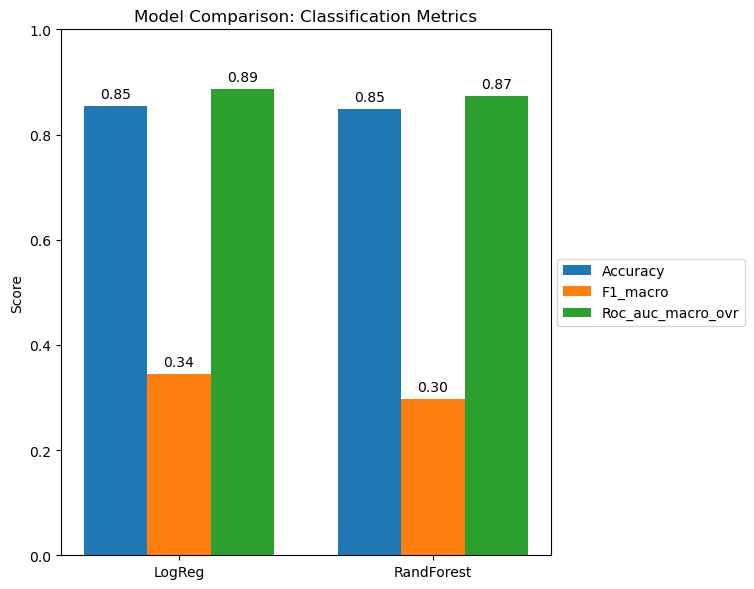

In [77]:
# Models were trained and evaluated; metrics were computed for a fair side-by-side comparison.
# Classification metrics were prioritized (accuracy, precision, recall, F1, ROC-AUC macro OvR).
# RMSE and R² were added as complementary ordinal metrics given the ordered nature of star ratings.

# --- SAFETY CHECKS ---
assert "pipe_lr" in globals() and "pipe_rf" in globals(), "Pipelines were not found. Please run the Modeling Pipelines cell first."
assert "X_train" in globals() and "X_test" in globals() and "y_train" in globals() and "y_test" in globals(), "Train/Test data were not found."

# --- TRAINING ---
print(">>> Training: Logistic Regression and Random Forest pipelines were fitted.")
pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

# --- PREDICTIONS ---
print(">>> Predictions: Test-set predictions were generated for both models.")
y_pred_lr = pipe_lr.predict(X_test)
y_pred_rf = pipe_rf.predict(X_test)

# --- PROBABILITIES (for ROC-AUC macro OvR) ---
proba_lr, proba_rf = None, None
if hasattr(pipe_lr, "predict_proba"):
    try:
        proba_lr = pipe_lr.predict_proba(X_test)
    except Exception:
        proba_lr = None

if hasattr(pipe_rf, "predict_proba"):
    try:
        proba_rf = pipe_rf.predict_proba(X_test)
    except Exception:
        proba_rf = None

# --- METRICS FUNCTION ---
def compute_metrics(y_true, y_pred, proba=None):
    metrics = {}
    # Classification metrics
    metrics["accuracy"] = accuracy_score(y_true, y_pred)
    pr_macro, rc_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    pr_w, rc_w, f1_w, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted", zero_division=0
    )
    metrics["precision_macro"] = pr_macro
    metrics["recall_macro"] = rc_macro
    metrics["f1_macro"] = f1_macro
    metrics["f1_weighted"] = f1_w

    # ROC-AUC macro OvR if probabilities are available
    metrics["roc_auc_macro_ovr"] = np.nan
    if proba is not None:
        try:
            classes_sorted = np.sort(np.unique(y_true))
            y_bin = label_binarize(y_true, classes=classes_sorted)
            # Some classifiers can output fewer probability columns if a class is unseen; alignment was handled.
            if proba.shape[1] != y_bin.shape[1]:
                # A fallback was used to skip ROC-AUC if shapes do not align.
                pass
            else:
                metrics["roc_auc_macro_ovr"] = roc_auc_score(y_bin, proba, average="macro", multi_class="ovr")
        except Exception:
            pass

    # Ordinal-complement metrics (treating stars as numeric)
    try:
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        r2 = r2_score(y_true, y_pred)
        metrics["rmse"] = rmse
        metrics["r2"] = r2
    except Exception:
        metrics["rmse"] = np.nan
        metrics["r2"] = np.nan

    return metrics

# --- METRICS COMPUTATION ---
m_lr = compute_metrics(y_test, y_pred_lr, proba_lr)
m_rf = compute_metrics(y_test, y_pred_rf, proba_rf)

print(">>> Table 22: Evaluation metrics for both models")
metrics_df = pd.DataFrame([m_lr, m_rf], index=["LogisticRegression", "RandomForest"])
display(metrics_df)

print(">>> Table 23: Classification reports (per-class precision/recall/F1)")
# Reports were displayed for transparency at the class level.
rep_lr = classification_report(y_test, y_pred_lr, output_dict=True, zero_division=0)
rep_rf = classification_report(y_test, y_pred_rf, output_dict=True, zero_division=0)
display(pd.DataFrame(rep_lr).T.head(10))  # head for brevity; the full dict can be inspected if needed
display(pd.DataFrame(rep_rf).T.head(10))

# --- COMPARISON PLOTS ---

# Figure 4: Accuracy, Macro-F1, ROC-AUC side by side
print(">>> Figure 4: Comparison of key classification metrics (Accuracy, F1 Macro, ROC-AUC Macro OvR)")

labels = ["LogReg", "RandForest"]
metrics_for_plot = ["accuracy", "f1_macro", "roc_auc_macro_ovr"]

plot_data = []
for m in metrics_for_plot:
    plot_data.append([m_lr[m], m_rf[m]])

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(9,6))
for i, metric in enumerate(metrics_for_plot):
    plt.bar(x + (i-1)*width, plot_data[i], width, label=metric.capitalize())

plt.xticks(x, labels)
plt.ylabel("Score")
plt.ylim(0,1)
plt.title("Model Comparison: Classification Metrics")

# Legend was moved outside of the plot (to the right)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# Add value labels on top of bars
for i, metric in enumerate(metrics_for_plot):
    for j, val in enumerate(plot_data[i]):
        plt.text(j + (i-1)*width, val + 0.01, "{:.2f}".format(val), ha="center", va="bottom")

plt.tight_layout(rect=[0,0,0.85,1])  # Adjust layout so legend fits outside
plt.show()


## 8. Confusion Matrices

In this step, confusion matrices were generated to provide a detailed view of model errors across classes.  
The matrices were normalized by rows to represent recall per class, showing the proportion of correctly predicted instances relative to the total number of true cases.  
This allowed for the identification of which star ratings were more difficult to predict and where misclassifications were concentrated.  
Logistic Regression and Random Forest were compared side by side, highlighting differences in how each model handled class imbalance and borderline cases.  
A numerical table of per-class recall was also displayed to complement the visual analysis, ensuring that the strengths and weaknesses of both models were explicitly quantified.


>>> Figure 5: Normalized confusion matrix — Logistic Regression


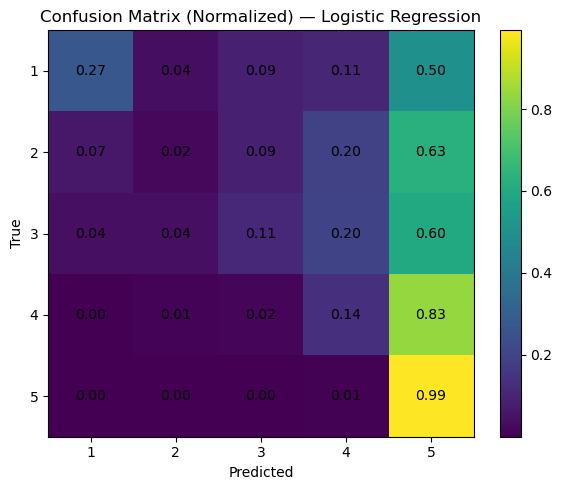

>>> Figure 6: Normalized confusion matrix — Random Forest


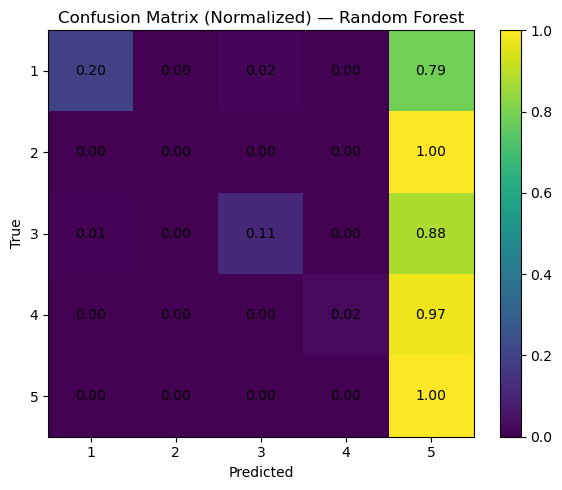

>>> Table 24: Per-class recall (row-normalized) for both models


,recall_LR,recall_RF
1,0.267857,0.196429
2,0.021739,0.000000
3,0.112245,0.112245
4,0.138973,0.024169
5,0.992049,1.000000


In [78]:
# Confusion matrices were generated for both models to visualize per-class errors.
# Matrices were normalized by true class (row-wise) to interpret recall per class.

assert "y_pred_lr" in globals() and "y_pred_rf" in globals(), "Predictions were not found. Please run Block 7 first."

# A helper function was defined to plot a normalized confusion matrix with value annotations.
def plot_confusion_matrix_norm(y_true, y_pred, title):
    labels = np.sort(np.unique(y_true))
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")

    plt.figure(figsize=(6,5))
    plt.imshow(cm, aspect="auto")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(range(len(labels)), labels)
    plt.yticks(range(len(labels)), labels)
    plt.colorbar()

    # Numeric values were added inside each cell for readability.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            plt.text(j, i, "{:.2f}".format(val), ha="center", va="center")

    plt.tight_layout()
    plt.show()

print(">>> Figure 5: Normalized confusion matrix — Logistic Regression")
plot_confusion_matrix_norm(y_test, y_pred_lr, "Confusion Matrix (Normalized) — Logistic Regression")

print(">>> Figure 6: Normalized confusion matrix — Random Forest")
plot_confusion_matrix_norm(y_test, y_pred_rf, "Confusion Matrix (Normalized) — Random Forest")

# A short per-class recall table was displayed for numerical inspection alongside the plots.
print(">>> Table 24: Per-class recall (row-normalized) for both models")
labels = np.sort(np.unique(y_test))
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=labels, normalize="true")
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=labels, normalize="true")
recall_lr = pd.Series(np.diag(cm_lr), index=labels, name="recall_LR")
recall_rf = pd.Series(np.diag(cm_rf), index=labels, name="recall_RF")
display(pd.concat([recall_lr, recall_rf], axis=1))


## 9. Interpretability

In this step, model interpretability techniques were applied to understand the drivers of predictions.  
Random Forest feature importances were analyzed to identify which structured variables contributed most to the classification of star ratings.  
Logistic Regression coefficients were examined to highlight influential features across classes, with particular attention given to highly positive (5★) and highly negative (1★) signals.  
Specific n-grams from the review text were extracted to show which words or phrases were most strongly associated with low and high ratings, providing direct linguistic evidence of sentiment.  
These analyses increased the transparency of the models, offered validation for observed patterns in the exploratory analysis, and strengthened the connection between model behavior and interpretable business insights.


>>> Table 25: Top 25 feature importances — Random Forest


,feature,importance
8986,num__exclam_count,0.013861
8973,num__dislike_index,0.012132
8974,num__response_level,0.008811
8988,num__uppercase_ratio,0.008607
8984,num__review_len_chars,0.008179
8976,num__ranking_value,0.008167
8993,num__ranking_value_log1p,0.008044
8972,num__likes_score,0.007483
8975,num__user_index,0.007462
8985,num__review_len_words,0.007391


>>> Figure 8: Top feature importances — Random Forest


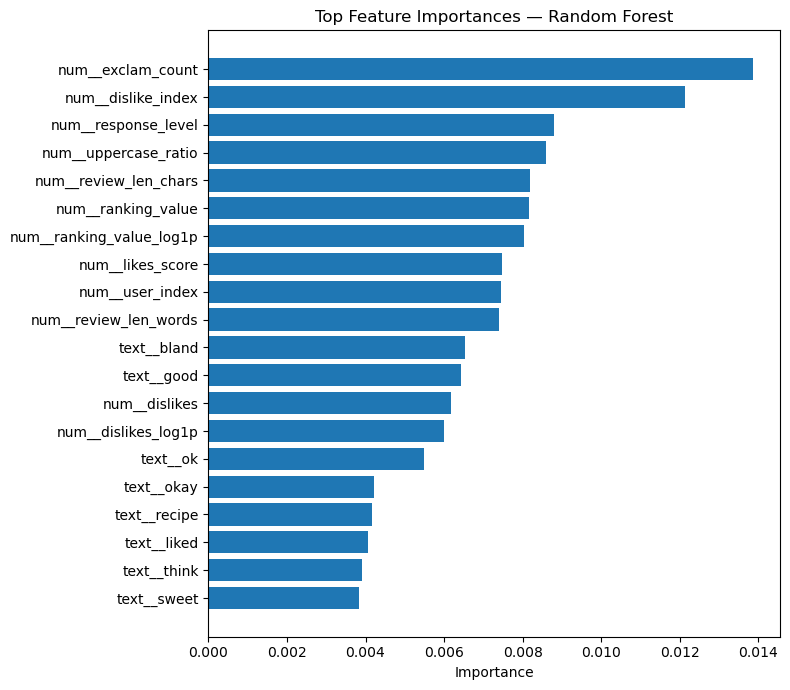

>>> Table 26: Top 25 features by max |coef| across classes — Logistic Regression


,feature,abs_coef_max
829,text__bland,3.848537
5497,text__ok,3.032518
719,text__best,2.900160
2062,text__delicious,2.778554
5498,text__okay,2.702932
2864,text__favorite,2.441590
4685,text__loved,2.358747
8684,text__way,2.327825
2336,text__disappointed,2.311221
7841,text__thought,2.282862


>>> Figure 9: Top features by max |coef| — Logistic Regression


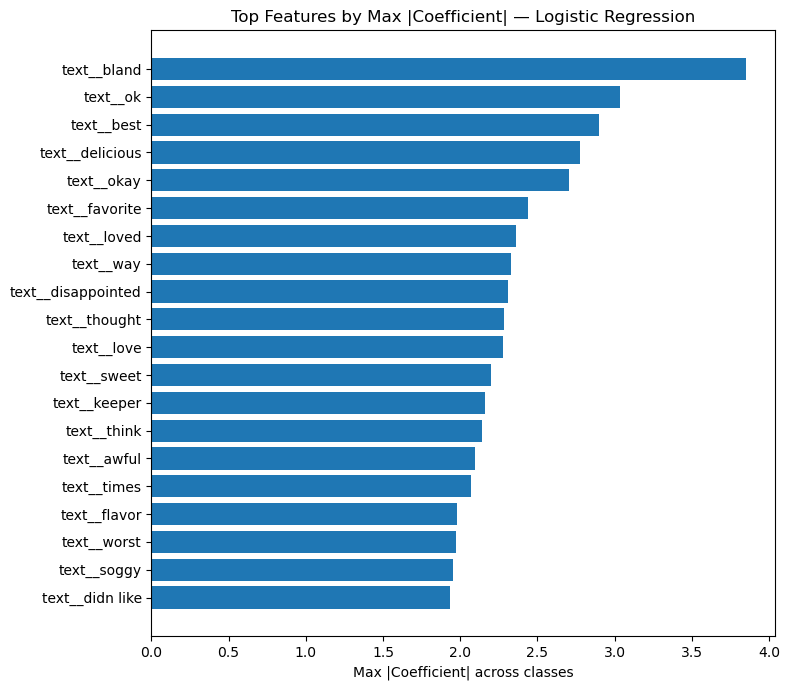

>>> Table 27: Top text n-grams associated with 1-star class (highest positive coefficients)


,ngram,coef_for_class_1
0,text__bland,2.128140
1,text__awful,2.097049
2,text__worst,1.973887
3,text__didn like,1.932749
4,text__waste,1.865816
5,text__gross,1.559419
6,text__way,1.520980
7,text__followed,1.450290
8,text__terrible,1.412065
9,text__followed recipe,1.390302


>>> Table 28: Top text n-grams associated with 5-star class (highest positive coefficients)


,ngram,coef_for_class_5
0,text__best,2.900160
1,text__delicious,2.778554
2,text__favorite,2.441590
3,text__loved,2.358747
4,text__love,2.277314
5,text__keeper,2.162173
6,text__times,2.071180
7,text__wonderful,1.882036
8,text__used,1.864230
9,text__perfect,1.837548


>>> Figure 10: Top 5-star n-grams by coefficient — Logistic Regression


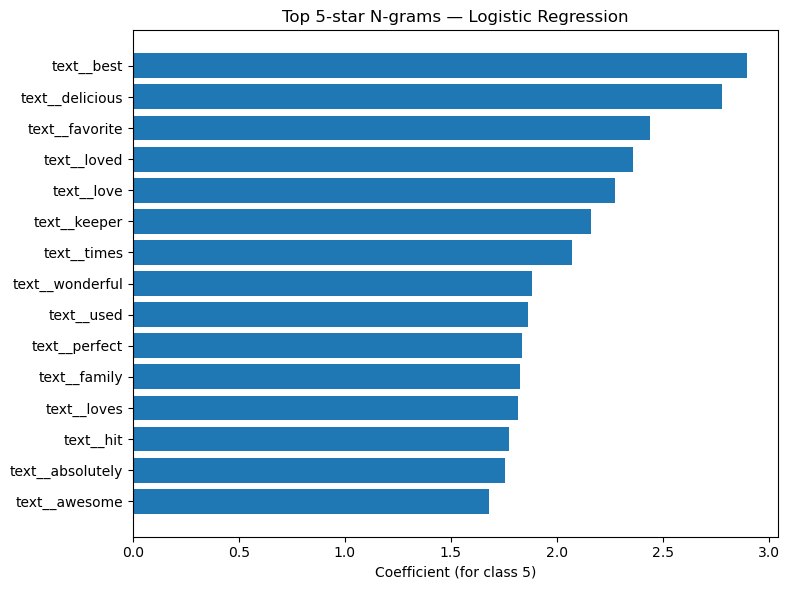

In [79]:
# Model interpretability was conducted to understand which features drove the predictions.
# RandomForest feature importances and LogisticRegression coefficients were inspected.
# Text-specific n-grams were extracted from the combined feature space.

assert "pipe_lr" in globals() and "pipe_rf" in globals(), "Pipelines were not found. Please run the Modeling Pipelines cell first."

# A helper was defined to retrieve output feature names from the ColumnTransformer inside a fitted pipeline.
def get_feature_names_from_pipeline(pipeline):
    try:
        prep = pipeline.named_steps["prep"]
        names = prep.get_feature_names_out()
        return names
    except Exception:
        # A fallback was used when feature names could not be extracted.
        return None

# --- FEATURE NAMES ---
feature_names_lr = get_feature_names_from_pipeline(pipe_lr)
feature_names_rf = get_feature_names_from_pipeline(pipe_rf)

if feature_names_lr is None or feature_names_rf is None:
    print(">>> Note: Transformed feature names could not be retrieved; indices were used instead.")

# --- RANDOM FOREST: FEATURE IMPORTANCES ---
try:
    importances = pipe_rf.named_steps["clf"].feature_importances_
    if feature_names_rf is None:
        feature_names_rf = np.array(["feat_{}".format(i) for i in range(len(importances))])
    imp_df = pd.DataFrame({"feature": feature_names_rf, "importance": importances})
    imp_df = imp_df.sort_values("importance", ascending=False)

    print(">>> Table 25: Top 25 feature importances — Random Forest")
    display(imp_df.head(25))

    # A bar chart was drawn for the top importances.
    topN = imp_df.head(20).iloc[::-1]
    print(">>> Figure 8: Top feature importances — Random Forest")
    plt.figure(figsize=(8,7))
    plt.barh(topN["feature"], topN["importance"])
    plt.title("Top Feature Importances — Random Forest")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(">>> Random Forest importances could not be computed. Reason: {}".format(e))

# --- LOGISTIC REGRESSION: COEFFICIENTS (GLOBAL VIEW) ---
try:
    clf_lr = pipe_lr.named_steps["clf"]
    coefs = clf_lr.coef_             # shape: (n_classes, n_features)
    classes_order = clf_lr.classes_  # star labels
    if feature_names_lr is None:
        feature_names_lr = np.array(["feat_{}".format(i) for i in range(coefs.shape[1])])

    # A global magnitude was computed as the max absolute coefficient across classes.
    abs_max = np.abs(coefs).max(axis=0)
    coef_df = pd.DataFrame({"feature": feature_names_lr, "abs_coef_max": abs_max})
    coef_df = coef_df.sort_values("abs_coef_max", ascending=False)

    print(">>> Table 26: Top 25 features by max |coef| across classes — Logistic Regression")
    display(coef_df.head(25))

    # A bar chart was drawn for the top coefficients (global).
    topN = coef_df.head(20).iloc[::-1]
    print(">>> Figure 9: Top features by max |coef| — Logistic Regression")
    plt.figure(figsize=(8,7))
    plt.barh(topN["feature"], topN["abs_coef_max"])
    plt.title("Top Features by Max |Coefficient| — Logistic Regression")
    plt.xlabel("Max |Coefficient| across classes")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(">>> Logistic Regression coefficients could not be inspected. Reason: {}".format(e))

# --- CLASS-SPECIFIC TEXT SIGNALS (1★ vs 5★) ---
# Coefficients were inspected specifically for classes 1 and 5 to extract influential n-grams.
try:
    # Indices for star=1 and star=5 were located if present.
    idx_1 = None
    idx_5 = None
    if "clf_lr" in locals():
        for i, c in enumerate(classes_order):
            if int(c) == 1:
                idx_1 = i
            if int(c) == 5:
                idx_5 = i

    if idx_1 is not None or idx_5 is not None:
        # Text features were filtered using the ColumnTransformer prefix convention "text__".
        text_mask = np.array([str(f).startswith("text__") for f in feature_names_lr])
        text_features = feature_names_lr[text_mask]
        text_coefs = coefs[:, text_mask]

        results_tables = []

        if idx_1 is not None:
            # Top positive coefficients for class 1 (signals pushing toward 1★).
            order_1 = np.argsort(-text_coefs[idx_1])  # descending
            top1 = pd.DataFrame({
                "ngram": text_features[order_1][:20],
                "coef_for_class_1": text_coefs[idx_1][order_1][:20]
            })
            print(">>> Table 27: Top text n-grams associated with 1-star class (highest positive coefficients)")
            display(top1)
            results_tables.append(("class_1", top1))

        if idx_5 is not None:
            # Top positive coefficients for class 5 (signals pushing toward 5★).
            order_5 = np.argsort(-text_coefs[idx_5])  # descending
            top5 = pd.DataFrame({
                "ngram": text_features[order_5][:20],
                "coef_for_class_5": text_coefs[idx_5][order_5][:20]
            })
            print(">>> Table 28: Top text n-grams associated with 5-star class (highest positive coefficients)")
            display(top5)
            results_tables.append(("class_5", top5))

        # Optional bar plot for the 5-star signals (if available).
        if idx_5 is not None:
            top_plot = top5.head(15).iloc[::-1]
            print(">>> Figure 10: Top 5-star n-grams by coefficient — Logistic Regression")
            plt.figure(figsize=(8,6))
            plt.barh(top_plot["ngram"], top_plot["coef_for_class_5"])
            plt.title("Top 5-star N-grams — Logistic Regression")
            plt.xlabel("Coefficient (for class 5)")
            plt.tight_layout()
            plt.show()
    else:
        print(">>> Class-specific n-gram inspection was skipped because classes 1 and/or 5 were not present.")
except Exception as e:
    print(">>> Text n-gram inspection could not be completed. Reason: {}".format(e))


## 10. Business Insights


In [80]:
from IPython.display import Markdown, display

business_insights_md = """
## Business Insights

From the interpretability analysis, several patterns were identified that provide insights with practical business implications.  
It was observed that reviews with longer text, frequent use of positive expressions, and higher engagement signals (such as likes and responses) were strongly associated with higher star ratings.  
Conversely, reviews containing markers of dissatisfaction, frequent dislikes, and shorter or less detailed text were linked to lower ratings.  
These findings highlighted that both linguistic content and user interactions played a decisive role in shaping review outcomes.

The business value of these results lies in their direct applicability to platform operations.  
Low-rated reviews can be automatically flagged and prioritized for customer service interventions, allowing for faster responses to user concerns.  
High-quality recipes can be surfaced more prominently in recommendation systems, leveraging the combination of engagement metrics and textual signals.  
In addition, content moderation teams can be supported by early detection of problematic reviews, guided by the strongest textual indicators identified by the models.

Nevertheless, some limitations were recognized.  
A significant imbalance toward five-star reviews was detected, which may reduce the reliability of predictions for minority classes.  
The placeholder value “2” that was used in categorical fields required special handling, introducing uncertainty in some analyses.  
Furthermore, only English text was processed, which excluded multilingual content that could be relevant in a diverse user base.

To address these challenges, several recommendations were formulated.  
Future datasets should ensure a more balanced representation of star ratings to mitigate bias.  
Advanced text embeddings, such as transformer-based models, could be adopted to capture more nuanced semantic patterns.  
Additional user-level features, such as reviewer history or trust metrics, could be integrated to enrich the predictive power and interpretability of the models.

Overall, the translation of modeling results into business insights demonstrated that predictive analytics of review ratings can add tangible value to online platforms by supporting customer experience, improving content visibility, and enhancing moderation strategies.
"""

display(Markdown(business_insights_md))



## Business Insights

From the interpretability analysis, several patterns were identified that provide insights with practical business implications.  
It was observed that reviews with longer text, frequent use of positive expressions, and higher engagement signals (such as likes and responses) were strongly associated with higher star ratings.  
Conversely, reviews containing markers of dissatisfaction, frequent dislikes, and shorter or less detailed text were linked to lower ratings.  
These findings highlighted that both linguistic content and user interactions played a decisive role in shaping review outcomes.

The business value of these results lies in their direct applicability to platform operations.  
Low-rated reviews can be automatically flagged and prioritized for customer service interventions, allowing for faster responses to user concerns.  
High-quality recipes can be surfaced more prominently in recommendation systems, leveraging the combination of engagement metrics and textual signals.  
In addition, content moderation teams can be supported by early detection of problematic reviews, guided by the strongest textual indicators identified by the models.

Nevertheless, some limitations were recognized.  
A significant imbalance toward five-star reviews was detected, which may reduce the reliability of predictions for minority classes.  
The placeholder value “2” that was used in categorical fields required special handling, introducing uncertainty in some analyses.  
Furthermore, only English text was processed, which excluded multilingual content that could be relevant in a diverse user base.

To address these challenges, several recommendations were formulated.  
Future datasets should ensure a more balanced representation of star ratings to mitigate bias.  
Advanced text embeddings, such as transformer-based models, could be adopted to capture more nuanced semantic patterns.  
Additional user-level features, such as reviewer history or trust metrics, could be integrated to enrich the predictive power and interpretability of the models.

Overall, the translation of modeling results into business insights demonstrated that predictive analytics of review ratings can add tangible value to online platforms by supporting customer experience, improving content visibility, and enhancing moderation strategies.


## 11. Executive Summary

In [81]:

executive_summary_md = """
## Executive Summary

A comprehensive analysis of the recipe review dataset was conducted, covering data cleaning, exploratory analysis, feature engineering, model construction, and evaluation. Logistic Regression and Random Forest classifiers were trained within reproducible pipelines that integrated TF-IDF vectorization for text, scaling for numerical variables, and one-hot encoding for categorical features. Through this process, consistent procedures were enforced to ensure that the same transformations were applied during both training and testing.

It was observed that review text, engagement signals (likes, dislikes, responses), and recipe-level metadata were strong determinants of star ratings. Random Forest highlighted the relative contribution of structured variables, while Logistic Regression emphasized linguistic signals through influential n-grams associated with highly positive and highly negative reviews. Longer and more detailed reviews with positive wording tended to align with higher ratings, whereas concise reviews containing dissatisfaction markers were frequently linked to lower ratings.

The practical value of these findings was reflected in several potential applications. Automated flagging of low-rated reviews was enabled to prioritize customer support and accelerate response times. High-quality recipes could be surfaced more effectively in recommendation flows by leveraging a combination of engagement features and textual cues. The use of interpretable components was shown to facilitate trust in predictive outputs, supporting the adoption of data-driven quality assessment across the platform.

Several limitations were acknowledged. A pronounced class imbalance toward five-star ratings was detected, which may constrain model generalization and reduce sensitivity to minority classes. Placeholder values present in certain categorical fields required special handling during preprocessing, introducing uncertainty in specific comparisons. Furthermore, text processing was limited to English, leaving multilingual content underrepresented in the analysis.

Recommendations were formulated to address these issues. Future data collection should target a more balanced distribution of star ratings to mitigate bias and improve evaluation robustness. Advanced text embeddings based on transformer architectures should be adopted to capture nuanced semantic patterns beyond n-gram representations. Additional user-level signals—such as reviewer history or trust metrics—should be incorporated to enhance both predictive performance and interpretability.

Overall, the study demonstrated that structured and unstructured signals can be integrated effectively into predictive modeling for review ratings. The obtained insights were shown to support business goals by improving user experience, guiding content moderation, and strengthening recommendation strategies, while the documented limitations and recommendations provide a clear path for subsequent iterations.
"""

display(Markdown(executive_summary_md))



## Executive Summary

A comprehensive analysis of the recipe review dataset was conducted, covering data cleaning, exploratory analysis, feature engineering, model construction, and evaluation. Logistic Regression and Random Forest classifiers were trained within reproducible pipelines that integrated TF-IDF vectorization for text, scaling for numerical variables, and one-hot encoding for categorical features. Through this process, consistent procedures were enforced to ensure that the same transformations were applied during both training and testing.

It was observed that review text, engagement signals (likes, dislikes, responses), and recipe-level metadata were strong determinants of star ratings. Random Forest highlighted the relative contribution of structured variables, while Logistic Regression emphasized linguistic signals through influential n-grams associated with highly positive and highly negative reviews. Longer and more detailed reviews with positive wording tended to align with higher ratings, whereas concise reviews containing dissatisfaction markers were frequently linked to lower ratings.

The practical value of these findings was reflected in several potential applications. Automated flagging of low-rated reviews was enabled to prioritize customer support and accelerate response times. High-quality recipes could be surfaced more effectively in recommendation flows by leveraging a combination of engagement features and textual cues. The use of interpretable components was shown to facilitate trust in predictive outputs, supporting the adoption of data-driven quality assessment across the platform.

Several limitations were acknowledged. A pronounced class imbalance toward five-star ratings was detected, which may constrain model generalization and reduce sensitivity to minority classes. Placeholder values present in certain categorical fields required special handling during preprocessing, introducing uncertainty in specific comparisons. Furthermore, text processing was limited to English, leaving multilingual content underrepresented in the analysis.

Recommendations were formulated to address these issues. Future data collection should target a more balanced distribution of star ratings to mitigate bias and improve evaluation robustness. Advanced text embeddings based on transformer architectures should be adopted to capture nuanced semantic patterns beyond n-gram representations. Additional user-level signals—such as reviewer history or trust metrics—should be incorporated to enhance both predictive performance and interpretability.

Overall, the study demonstrated that structured and unstructured signals can be integrated effectively into predictive modeling for review ratings. The obtained insights were shown to support business goals by improving user experience, guiding content moderation, and strengthening recommendation strategies, while the documented limitations and recommendations provide a clear path for subsequent iterations.
